## To-do list:  
1. Create parking data
2. Model to provide dynamic pricing (i/p: numpy array (area_type, time), o/p: price)
3. Integrate into website? (edit: scrapped)

Data creation:  
Format—   
Input is in the form [is_weekend, time]  
Output is in the form [probability_of_free_lots]  
Both numpy arrays

In [1]:
import numpy as np
import pandas as pd

In [2]:
base = 20

In [3]:
np.random.seed(15) # Just setting a randomising key so that we can reproduce our results
n_samples = 3000

In [4]:
bangalore_pincodes = np.arange(560001, 560100)  # Main city pincodes

# Add outer area pincodes
outer_pincodes = np.array([562106, 562107, 562125, 562130, 562149, 562157])
area_code = np.concatenate([bangalore_pincodes, outer_pincodes])

crowded_areas = {
    560016: 1.8,  # KR Puram - ORR entry, extremely crowded
    560037: 1.7,  # Marathahalli - ORR tech corridor
    560034: 1.6,  # Koramangala - Central business district
    560076: 1.6,  # Bannerghatta Road - IT corridor
    560102: 1.5,  # HSR Layout - Residential + IT
    560068: 1.5,  # Bommanahalli - Industrial area
    560043: 1.4,  # Banaswadi - Dense residential
    560058: 1.4,  # Peenya - Industrial area
    560064: 1.3,  # Yelahanka - Airport corridor
    560038: 1.3,  # Indiranagar - Commercial hub
}

print(f"Total Bangalore pincodes: {len(area_code)}")
print(f"Pincode range: {area_code.min()} - {area_code.max()}")
print(f"Array: {area_code}")

Total Bangalore pincodes: 105
Pincode range: 560001 - 562157
Array: [560001 560002 560003 560004 560005 560006 560007 560008 560009 560010
 560011 560012 560013 560014 560015 560016 560017 560018 560019 560020
 560021 560022 560023 560024 560025 560026 560027 560028 560029 560030
 560031 560032 560033 560034 560035 560036 560037 560038 560039 560040
 560041 560042 560043 560044 560045 560046 560047 560048 560049 560050
 560051 560052 560053 560054 560055 560056 560057 560058 560059 560060
 560061 560062 560063 560064 560065 560066 560067 560068 560069 560070
 560071 560072 560073 560074 560075 560076 560077 560078 560079 560080
 560081 560082 560083 560084 560085 560086 560087 560088 560089 560090
 560091 560092 560093 560094 560095 560096 560097 560098 560099 562106
 562107 562125 562130 562149 562157]


In [5]:
codes = np.random.choice(list(crowded_areas.keys()) + [pc for pc in area_code if pc not in crowded_areas], n_samples)
hours = np.random.randint(0, 24, n_samples)

In [6]:
def bell_curve_price(area_type, hour):
    base = 20

    # Area type: 0=normal, 1=crowded
    crowding_factor = 1.8 if area_type == 1 else 1.0

    # Bell curve 1: Morning peak centered at 9:30 AM
    morning_peak = np.exp(-((hour - 9.5) ** 2) / (2 * 1.5 ** 2))  # σ=1.5 hours

    # Bell curve 2: Evening peak centered at 7:00 PM
    evening_peak = np.exp(-((hour - 19) ** 2) / (2 * 1.0 ** 2))   # σ=1.0 hours

    # Combine peaks (1.5x morning + 1.0x evening)
    peak_multiplier = 1.0 + 1.5 * morning_peak + 1.0 * evening_peak  # 1.0x to 3.5x

    price = base * crowding_factor * peak_multiplier
    return price

In [7]:
area_types = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
hours = np.random.randint(0, 24, n_samples)
prices = [bell_curve_price(at, hr) for at, hr in zip(area_types, hours)]

In [8]:
arr_in = np.column_stack([area_types, hours])
arr_out = np.array(prices)

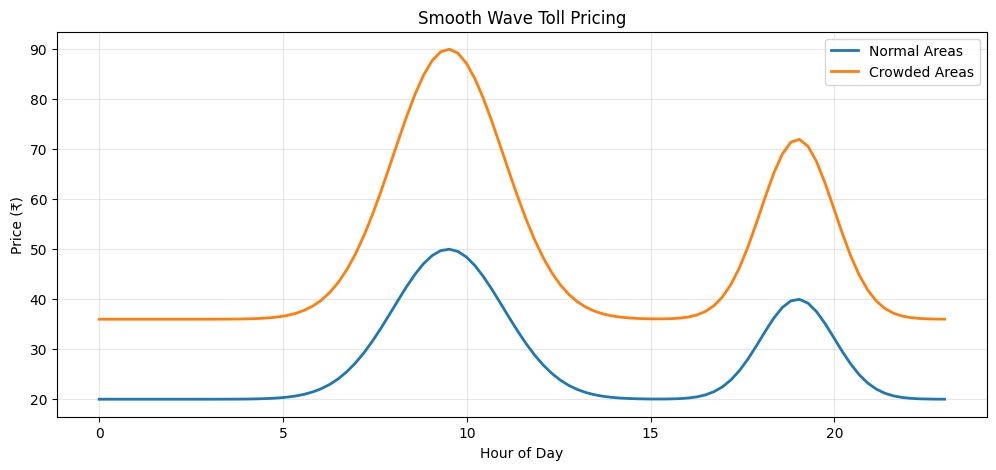

In [9]:
# I used GenAI to create this because I j wanted to see my data rq

import matplotlib.pyplot as plt

test_hours = np.linspace(0, 23, 100)
normal_prices = [bell_curve_price(0, h) for h in test_hours]
crowded_prices = [bell_curve_price(1, h) for h in test_hours]

plt.figure(figsize=(12, 5))
plt.plot(test_hours, normal_prices, label='Normal Areas', linewidth=2)
plt.plot(test_hours, crowded_prices, label='Crowded Areas', linewidth=2)
plt.title('Smooth Wave Toll Pricing')
plt.xlabel('Hour of Day')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Now the model. I'll do a neural nwk because it's good w non-linear data and can be run directly on the ESP32.  
Edit: No space on the ESP32 so this will just be a proof-of-concept code.

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [11]:
def tinyml_rf():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

In [12]:
x_train, x_test, y_train, y_test = train_test_split(arr_in, arr_out, test_size=0.2, random_state=45)

In [13]:
tiny = tinyml_rf()
tiny.fit(x_train, y_train, epochs=100, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from sklearn.metrics import r2_score

test_predictions = tiny.predict(x_test).flatten()
mae = np.mean(np.abs(y_test - test_predictions))
r_squared = r2_score(y_test, test_predictions)

print(f"Model Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model R-squared: {r_squared:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model Mean Absolute Error (MAE): 3.93
Model R-squared: 0.86


In [15]:
# Save trained model in case we wanna try server-hosting. Not needed for now.
tiny.save('toll_model.keras')
print("Model saved as 'toll_model.keras'")

# Test it loads
test_model = tf.keras.models.load_model('toll_model.keras')
test_input1 = np.array([[1, 8]], dtype=np.float32)
prediction1 = tiny.predict(test_input1)[0][0]

test_input2 = np.array([[0, 9.30]], dtype=np.float32)
prediction2 = tiny.predict(test_input2)[0][0]

print(f"🧪 Test prediction: ₹{prediction1:.1f}")
print(f"🧪 Test prediction: ₹{prediction2:.1f}")

Model saved as 'toll_model.keras'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🧪 Test prediction: ₹67.7
🧪 Test prediction: ₹52.6
